In [120]:
import pandas as pd
import pprint
from impyute.imputation.cs import mice#
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer#
import missingno as msno#
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform, pdist
from missingpy import KNNImputer
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set()
pd.set_option("display.max_rows", 8)
plt.rcParams['figure.figsize'] = (9, 6)
from missingpy import MissForest
import io
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn import decomposition
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

In [3]:
Dapp = pd.read_csv("horse-colic.data" , sep = "\s+", names = ["V"+str(i) for i in range(28)])
Dtest = pd.read_csv("horse-colic.test" , sep = "\s+", names = ["V"+str(i) for i in range(28)])
liste_drop = ["V22","V23","V24","V25","V26","V27"]
Dapp = Dapp.drop(liste_drop , axis = 1)
Dtest = Dtest.drop(liste_drop , axis = 1)
Dapp = Dapp.replace("?",np.nan)
Dtest = Dtest.replace("?",np.nan)

#Dtest
#Dapp
#On utilisera une méthode d'imputation qui gère différentes types pour les variables ! (cf Référence)
#On se doit tout de même spécifier le type des variables


In [4]:
d = {}
liste_categorical = [] ; liste_numerical = []
for i in range(22):
    if(i in list(range(3)) + list(range(6 , 15)) + [16 , 17 , 20]):
        d["V"+str(i)] = "category"
        liste_categorical.append("V"+str(i))
    else:
        d["V"+str(i)] = "float64"
        liste_numerical.append("V"+str(i))
liste_categorical
liste_numerical

['V3', 'V4', 'V5', 'V15', 'V18', 'V19', 'V21']

In [15]:
label_V2 = list(set(list(Dapp.V2.unique()) + list(Dtest.V2.unique()) ))
label_V2 = [str(x) for x in label_V2]


In [16]:
Dapp = Dapp.astype(d)
Dtest = Dtest.astype(d)
Dapp_num = Dapp.select_dtypes(include=['float64']) ; Dapp_cat = Dapp.select_dtypes(include=['category'])
Dtest_num = Dtest.select_dtypes(include=['float64']) ; Dtest_cat = Dtest.select_dtypes(include=['category'])
Dtest_cat.loc[: , "V9"] = pd.Series(pd.Categorical(Dtest_cat.loc[: , "V9"], categories=["1","2","3"]))
Dtest_cat.loc[: , "V2"] = Dtest_cat.loc[: , "V2"].astype("str")
Dapp_cat.loc[: , "V2"] = Dapp_cat.loc[: , "V2"].astype("str")
Dtest_cat.loc[: , "V2"] = pd.Series(pd.Categorical(Dtest_cat.loc[: , "V2"], categories=label_V2))
Dapp_cat.loc[: , "V2"] = pd.Series(pd.Categorical(Dapp_cat.loc[: , "V2"], categories=label_V2))


In [17]:
def g(l):
    return np.array([float(x) for x in l])

imputed_training=mice(np.array(list(map(g , Dapp_num.values))))
imputed_test = mice(np.array(list(map(g , Dtest_num.values))))

Dapp_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputed_training))))).round(2)
Dapp_num_imputed.columns = liste_numerical

Dtest_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputed_test))))).round(2)
Dtest_num_imputed.columns = liste_numerical

In [18]:
## On a généré quelques valeurs négatives, il est nécessaire d'effectuer de nouvelles imputations sur nos données
Dapp_num_imputed[Dapp_num_imputed < 0] = np.nan
Dtest_num_imputed[Dtest_num_imputed < 0] = np.nan

distances_app = pdist(Dapp_num_imputed.values, metric='euclidean')
dist_matrix_app = squareform(distances_app)
matrice_distance_app = pd.DataFrame(list(map(np.ravel, (list(dist_matrix_app))))).round(2)

distances_test = pdist(Dtest_num_imputed.values, metric='euclidean')
dist_matrix_test = squareform(distances_test)
matrice_distance_test = pd.DataFrame(list(map(np.ravel, (list(dist_matrix_test))))).round(2)
#on ne peut pas se permettre de prendre des poids uniformes
#en effet, il se peut que le 2e plus proche soit en réalité très loin du point par rapport au premier

imputer = KNNImputer(n_neighbors=15, weights="distance")
Dapp_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputer.fit_transform(Dapp_num_imputed)))))).round(2)

imputer = KNNImputer(n_neighbors=3, weights="distance")
Dtest_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputer.fit_transform(Dtest_num_imputed)))))).round(2)

Dapp_num_imputed.columns = liste_numerical ; Dtest_num_imputed.columns = liste_numerical
#le choix du nombre de voisins est difficile, on fait donc des choix arbitraires


C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)


In [ ]:
{lab : 1-(len(Dtest_num[lab].dropna())/len(Dtest_num)) for lab in liste_numerical} 
{lab : 1-(len(Dapp_num[lab].dropna())/len(Dapp_num)) for lab in liste_numerical} 


In [ ]:
x = Dapp_num.V21
y = Dapp_num_imputed.V21
#L'objectif est de comparer les distributions pour voir si l'on observe une certaine cohérence après imputation
#on compare les distributions avant/après
#on calcule aussi la proportion de données manquantes pour être sûr que la comparaison ait un sens.
#il faut que le % de données manquantes ne soit ni trop faible ni trop élevé pour pouvoir comparer
#on peut faire une "évaluation" visuelle de notre imputation sur cette variable choisie
plt.hist([x, y], label=['Missing data', 'Imputed data'] , color = ["plum","peru"])
plt.legend(loc='upper right')
plt.show()

In [19]:
#Dapp_cat = Dapp_cat.drop(["V2"] , axis = 1) ; Dtest_cat = Dtest_cat.drop(["V2"] , axis = 1)
cat_cols = [Dapp_cat.columns.get_loc(col) for col in Dapp_cat.select_dtypes(['category']).columns.tolist()]

imputer = MissForest(random_state = 100)
Dapp_cat_imputed = imputer.fit_transform(Dapp_cat , cat_vars = cat_cols)
Dapp_cat_imputed = pd.DataFrame(list(map(np.ravel, (list(Dapp_cat_imputed)))))
Dapp_cat_imputed.columns = [x for x in liste_categorical] #if(x!="V2")
Dapp_cat_imputed = Dapp_cat_imputed.apply(lambda x : x.astype(int).astype(str).astype("category") , axis = 1)
Dapp_cat_imputed.loc[: , "V2"] = Dapp_cat_imputed.loc[: , "V2"].astype("str")
Dapp_cat_imputed.loc[: , "V2"] = pd.Series(pd.Categorical(Dapp_cat_imputed.loc[: , "V2"], categories=label_V2))


Dtest_cat_imputed = imputer.transform(Dtest_cat)
Dtest_cat_imputed = pd.DataFrame(list(map(np.ravel, (list(Dtest_cat_imputed)))))
Dtest_cat_imputed.columns = [x for x in liste_categorical] #if(x!="V2")
Dtest_cat_imputed = Dtest_cat_imputed.apply(lambda x : x.astype(int).astype(str).astype("category") , axis = 1)
Dtest_cat_imputed.loc[: , "V9"] = pd.Series(pd.Categorical(Dtest_cat_imputed.loc[: , "V9"], categories=["1","2","3"]))
Dtest_cat_imputed.loc[: , "V2"] = Dtest_cat_imputed.loc[: , "V2"].astype("str")
Dtest_cat_imputed.loc[: , "V2"] = pd.Series(pd.Categorical(Dtest_cat_imputed.loc[: , "V2"], categories=label_V2))
#une modalité de V9 n'est pas présente dans la variable V9 des données de test : il faut rajouter une catégorie
#pour la variable V9 des données de test

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [ ]:
{lab : 1-(len(Dtest_cat[lab].dropna())/len(Dtest)) for lab in liste_categorical if(lab != "V2")} 
{lab : 1-(len(Dapp_cat[lab].dropna())/len(Dapp)) for lab in liste_categorical if(lab != "V2")}
#les proportions de données manquantes pour chaque varible

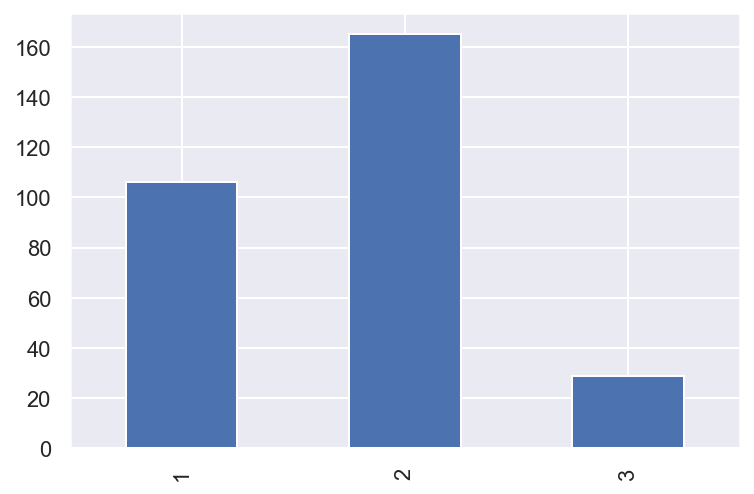

In [20]:
Dapp_cat_imputed.V13.value_counts().sort_index().plot(kind = "bar")
#en pratique, il est nécessaire de vérifier la distribution des variables avant\après imputation
#on trace donc des barplot pour avoir une idée

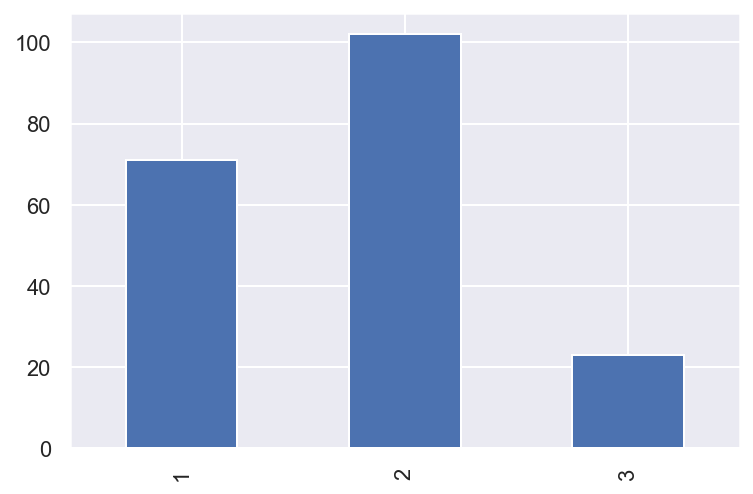

In [21]:
Dapp_cat["V13"].value_counts().sort_index().plot(kind = "bar")

In [22]:
Dapp_imputed = pd.concat([Dapp_num_imputed.reset_index(drop=True), Dapp_cat_imputed], axis=1)
Dapp_imputed.columns = [int(x[1:]) for x in Dapp_imputed.columns]
Dapp_imputed = Dapp_imputed.sort_index(axis = 1)
Dapp_imputed.columns = ["V"+str(x) for x in Dapp_imputed.columns]

Dtest_imputed = pd.concat([Dtest_num_imputed.reset_index(drop=True), Dtest_cat_imputed], axis=1)
Dtest_imputed.columns = [int(x[1:]) for x in Dtest_imputed.columns]
Dtest_imputed = Dtest_imputed.sort_index(axis = 1)
Dtest_imputed.columns = ["V"+str(x) for x in Dtest_imputed.columns]
Dtest_imputed

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
0,2,1,528626,38.5,54.0,20.0,3,1,2,2,...,1,2,2,5.90,4,2,42.0,6.3,2,4.61
1,2,1,527950,37.6,48.0,36.0,1,1,1,1,...,2,2,1,5.73,3,5,44.0,6.3,1,5.00
2,1,1,535263,37.7,44.0,28.0,3,4,3,2,...,4,1,1,4.91,3,5,45.0,70.0,3,2.00
3,1,1,534523,37.0,56.0,24.0,3,1,4,2,...,3,1,1,4.31,4,5,35.0,61.0,3,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2,1,528452,37.8,42.0,40.0,1,1,1,1,...,1,2,1,7.47,3,3,36.0,6.2,1,2.97
65,1,1,534783,38.0,60.0,12.0,1,1,2,1,...,1,1,1,4.37,1,4,44.0,65.0,3,2.00
66,2,1,528926,38.0,42.0,12.0,3,1,3,1,...,1,2,1,6.39,4,1,37.0,5.8,2,3.20
67,2,1,530670,37.6,88.0,36.0,3,1,1,1,...,2,1,3,1.50,4,4,44.0,6.0,2,10.20


In [ ]:
Dapp_imputed

In [286]:
#Dtest_imputed.to_pickle("Dtest_imputed.pkl")
#Dapp_imputed.to_pickle("Dapp_imputed.pkl")

In [287]:
Dapp_imputed = pd.read_pickle("Dapp_imputed.pkl")
Dtest_imputed = pd.read_pickle("Dtest_imputed.pkl")

In [23]:
liste_cat_bis = [x for x in liste_categorical if(x not in ["V0"] )]

In [24]:
scaler = StandardScaler()
Dapp_imputed[liste_numerical] = scaler.fit_transform(Dapp_imputed[liste_numerical])
Dapp_imputed["V0"] = pd.Series([1 if(x=="1") else 0 for x in Dapp_imputed["V0"]])
Dapp_imputed = Dapp_imputed.astype({"V0" : "int32"})
Dapp_imputed = pd.get_dummies(Dapp_imputed , columns = liste_cat_bis , drop_first = True)

Dtest_imputed[liste_numerical] = scaler.transform(Dtest_imputed[liste_numerical])
Dtest_imputed["V0"] = pd.Series([1 if(x=="1") else 0 for x in Dtest_imputed["V0"]])
Dtest_imputed = Dtest_imputed.astype({"V0" : "int32"})
Dtest_imputed = pd.get_dummies(Dtest_imputed , columns = liste_cat_bis , drop_first = True)

Dapp_imputed
Dtest_imputed

,V0,V3,V4,V5,V15,V18,V19,V21,V1_9,V2_530439,...,V14_3,V16_2,V16_3,V16_4,V17_2,V17_3,V17_4,V17_5,V20_2,V20_3
0,0,0.499926,-0.646563,-0.653774,0.685917,-0.431954,-0.697744,1.137392,0,0,...,0,0,0,1,1,0,0,0,1,0
1,0,-0.869317,-0.861507,0.336586,0.596896,-0.230903,-0.697744,1.410798,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,-0.717179,-1.004802,-0.158594,0.167499,-0.130378,1.762025,-0.692325,0,0,...,0,0,1,0,0,0,0,1,0,1
3,1,-1.782146,-0.574915,-0.406184,-0.146693,-1.135631,1.414491,-0.692325,0,0,...,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0,-0.565041,-1.076450,0.584176,1.508054,-1.035106,-0.701606,-0.012315,0,0,...,0,0,1,0,0,1,0,0,0,0
65,1,-0.260765,-0.431619,-1.148953,-0.115274,-0.230903,1.568950,-0.692325,0,0,...,0,0,0,0,0,0,1,0,0,1
66,0,-0.260765,-1.076450,-1.148953,0.942508,-0.934581,-0.717052,0.148924,0,0,...,0,0,0,1,0,0,0,0,1,0
67,0,-0.869317,0.571452,0.336586,-1.618161,-0.230903,-0.709329,5.056210,0,0,...,1,0,0,1,0,0,1,0,1,0


In [25]:
Dapp_imputed

,V0,V3,V4,V5,V15,V18,V19,V21,V1_9,V2_530439,...,V14_3,V16_2,V16_3,V16_4,V17_2,V17_3,V17_4,V17_5,V20_2,V20_3
0,0,0.499926,-0.216675,-0.158594,0.570713,-0.130378,-0.616653,0.352226,0,0,...,0,0,1,0,0,0,0,1,0,1
1,1,1.564893,0.571452,-0.653774,-1.586742,0.372249,2.341248,-0.692325,0,0,...,0,0,0,1,1,0,0,0,1,0
2,0,0.195650,-1.148098,-0.406184,0.743519,-1.336682,-0.682298,0.176966,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1.412754,3.294073,3.307665,0.214628,0.171198,-0.662991,1.621110,1,0,...,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0,-1.477870,-0.001731,-0.406184,-0.240951,-0.230903,-0.072955,0.219029,0,0,...,0,0,0,1,0,0,1,0,0,1
297,1,-1.021455,-0.001731,-0.034799,0.596896,1.377502,-0.678437,0.499445,0,0,...,0,0,1,0,0,0,0,1,0,1
298,1,-2.542836,1.001339,-0.406184,-0.686057,0.372249,-0.709329,0.289133,0,0,...,0,0,0,1,0,0,1,0,0,1
299,1,-1.477870,-1.148098,-0.653774,-1.372044,-1.035106,1.453105,-1.393365,0,0,...,0,0,0,1,0,0,0,0,0,0


In [26]:
X_train = Dapp_imputed.drop(["V0"] , axis = 1) ; Y_train = Dapp_imputed["V0"]
X_test = Dtest_imputed.drop(["V0"] , axis = 1) ; Y_test = Dtest_imputed["V0"]
#Voici nos jeux de données d'entrainement ainsi que de tests

In [27]:
np.linalg.det(np.dot(np.transpose(X_train) , X_train)) #la matrice de design n'est pas de rang plein, rien ne nous garantit que
#que l'on atteindra un minimum global en faisant une régression logistique
#on décide de pénaliser celle-ci avec une pénalité de type ridge

0.0

In [61]:
def param_selection_log(X, y,Cs):
    logreg = LogisticRegression(penalty = "l2", solver = "lbfgs" , max_iter = 5000 , tol = 1e-6)
    parameters = {'C':Cs}
    clf = GridSearchCV(logreg, parameters, cv = KFold(n_splits = 300))
    clf.fit(X_train, Y_train)
    return clf.best_params_

C_log = param_selection_log(X_train, Y_train , [.001 , 0.01 , 0.1 , 1 , 10 , 100])["C"]
#Naturellement, on se dirigera vers les SVM non linéaires de manière à déterminer un hyperplan dans un espace 
#de plus grande dimension

logreg = LogisticRegression(penalty = "l2", solver = "lbfgs" , max_iter = 5000 , tol = 1e-6 , C = C_log)
logreg.fit(X_train , Y_train)
y_pred = logreg.predict(X_test)
y_fit = logreg.predict(X_train)
accuracy_score(y_pred, Y_test)

0.7941176470588235

In [ ]:
accuracy_score(y_fit, Y_train) #on dipose d'une erreur d'apprentissage nulle
#cela laisse présager du sur-apprentissage --> dès lors on peut remettre en doute notre performance
#de plus, on constate qu'il existe une séparation linéaire des données
#nous allons donc utiliser un autre classifieur linéaire : SVML
#une SVM à noyaux est inutile

In [63]:
Y_train = pd.Series([-1 if(y==0) else 1 for y in Y_train])
Y_test = pd.Series([-1 if(y==0) else 1 for y in Y_test])

In [69]:
def svc_param_selection_lin(X, y,Cs):
    parameters = {'kernel':['linear'], 'C':Cs}
    svc = svm.SVC(gamma = 1 , coef0 = 0)
    clf = GridSearchCV(svc, parameters , return_train_score = True , cv = KFold(n_splits = 3))
    clf.fit(X_train, Y_train)
    return clf.best_params_
##on effectue une VC 3-fold car moins coûteuse
C_lin = svc_param_selection_lin(X_train, Y_train , [.001 , 0.01 , 0.1 , 1 , 10 , 100])["C"]

svm_lin = LinearSVC(C = C_lin , max_iter = 10000)
svm_lin.fit(X_train , Y_train)
y_pred = svm_lin.predict(X_test)
y_fit = svm_lin.predict(X_train)
accuracy_score(y_pred, Y_test)
#même performance que la régression logistique et même problème que la régression logistique
#tout laisse penser que l'on est face à un problème de sur-apprentissage


0.8088235294117647

In [70]:
accuracy_score(y_fit, Y_train)


1.0

In [77]:
def svc_param_selection_poly(X, y,Cs , degree):
    Cs = list(np.unique([round(x,3) for x in Cs]))
    parameters = {'kernel':['poly'], 'C':Cs , "degree" : degree}
    svc = svm.SVC(gamma = "auto")
    clf = GridSearchCV(svc, parameters , return_train_score = True , cv = KFold(n_splits = 3))
    clf.fit(X_train, Y_train)
    return clf.best_params_
params_poly = svc_param_selection_poly(X_train, Y_train , [.001 , 0.01 , 0.1 , 1 , 10 , 100 , 1000] , list(range(1,4)))
ksvm_poly = svm.SVC(kernel="poly", degree = params_poly["degree"] , C = params_poly["C"] , gamma = "auto")               
ksvm_poly.fit(X_train, Y_train)
y_pred = ksvm_poly.predict(X_test)
y_fit = ksvm_poly.predict(X_train)
accuracy_score(y_pred, Y_test)
## même constat pour ce modèle, on retrouve une SVM linéaire avec une erreur d'ajustement nulle
#choisir le paramètre du modèle selon la validation croisée nous amnère dans les 3 denrières méthodes utilisées à choisir
#la complexité la plus grande

0.7941176470588235

In [80]:
accuracy_score(y_fit, Y_train)


1.0

In [ ]:
params_poly

In [81]:
def oob_m(liste): #renvoie le m minimisant l'erreur OOB
    l = []
    for m in liste:
        clf = RandomForestClassifier(random_state = 0,
                             n_estimators = 100 , max_features = m , min_samples_split = 2,
                            oob_score = True)
        clf.fit(X_train, Y_train)
        l.append((m , clf.oob_score_))
    return min(l , key = lambda x : x[1])[0]

m = oob_m(range(1,8))

In [82]:
clf = RandomForestClassifier(random_state = 0,
                             n_estimators = 100 , max_features = m , min_samples_split = 2,
                            oob_score = True)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
y_fit = clf.predict(X_train)
accuracy_score(y_pred, Y_test)
#accuracy_score(y_fit, Y_train)

#moins performante que les précédentes mais l'erreur d'ajustement est nulle aussi

0.7352941176470589

In [83]:
accuracy_score(y_fit, Y_train)

1.0

In [84]:
def rfc_CV(ms):
    rfc = RandomForestClassifier(random_state = 0, min_samples_split = 2,
                            oob_score = True , n_estimators = 100)
    param_grid = {'max_features': ms}
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= KFold(n_splits = 3))
    CV_rfc.fit(X_train, Y_train)
    return CV_rfc.best_params_["max_features"]
#on décide de faire une 3-fold car la LOO est coûteuse

In [85]:
ms = list(range(1,6))
m = rfc_CV(ms)
rfc = RandomForestClassifier(random_state = 0,
                             n_estimators = 100 , max_features = m , min_samples_split = 2,
                            oob_score = True)
rfc.fit(X_train, Y_train)
y_pred = rfc.predict(X_test)
y_fit = rfc.predict(X_train)
accuracy_score(y_pred, Y_test)
accuracy_score(y_fit, Y_train)
#idem que précédemment

0.7647058823529411

In [115]:
def knn_CV(ks):
    neigh = KNeighborsClassifier()
    param_grid = {'n_neighbors': ks}
    CV_knn = GridSearchCV(estimator=neigh, param_grid=param_grid, cv= KFold(n_splits = 3))
    CV_knn.fit(X_train, Y_train)
    return CV_knn.best_params_["n_neighbors"]
k = knn_CV(list(range(1,100)))

In [116]:
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, Y_train)
y_pred = neigh.predict(X_test)
y_fit = neigh.predict(X_train)
accuracy_score(y_pred, Y_test)
#accuracy_score(y_fit , Y_train)
#aussi surprenant que cela puisse paraître le modèle qui ne semble pas souffrir de sur-apprentissage
#est k-ppv 

0.7794117647058824

In [94]:
k

22

In [117]:
accuracy_score(y_fit , Y_train)

0.7433333333333333

In [104]:
def ada_CV(ns):
    ada = AdaBoostClassifier(random_state=0)
    param_grid = {'n_estimators': ns}
    CV_ada = GridSearchCV(estimator=ada, param_grid=param_grid, cv= KFold(n_splits = 3))
    CV_ada.fit(X_train, Y_train)
    return CV_ada.best_params_["n_estimators"]
B = ada_CV(list(range(1,100)))

In [105]:
ada = AdaBoostClassifier(n_estimators = B, random_state=0)
ada.fit(X_train, Y_train)
y_pred = ada.predict(X_test)
y_fit = ada.predict(X_train)
accuracy_score(y_pred, Y_test)


0.7647058823529411

In [106]:
(accuracy_score(y_fit, Y_train))
#ce modèle semble aussi souffrir de sur-apprentissage : avec une grille plus large, nous n'aurions pas d'erreur
#d'ajustement

0.9633333333333334

In [130]:
def dtree_grid_search(X,y,depth):
    param_grid = {'max_depth': depth}
    dtree_model=DecisionTreeClassifier(random_state = 0)
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv= KFold(n_splits = 3))
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

P = dtree_grid_search(X_train,Y_train,list(range(3,100)))["max_depth"]

arb = DecisionTreeClassifier(random_state=0 , max_depth = P)

In [132]:
arb.fit(X_train, Y_train)
y_pred = arb.predict(X_test)
y_fit = arb.predict(X_train)
accuracy_score(y_pred, Y_test)

0.7647058823529411

In [133]:
accuracy_score(y_fit, Y_train) #idem pour ce modèle

0.9366666666666666